In [415]:
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from matplotlib import pyplot
np.random.seed(2017) # set random seed value to get reproducible results

In [416]:
# store start time to get execution time of entire script
start_time = time.time()

### Load Data

In [417]:
df = pd.read_csv('data_cleaned.csv', index_col=[0])
print(df.shape)
df.head()

(5458, 39)


,engage30,init,female_cd,nonwhite_cd,unemplmt_cd,primsev_cd,prsatx_cd,TRIg_0_cd,TMIg_0_cd,SESg_0_cd,gvsg_cd,tsd_0_cd,und15_cd,CWSg_0_cd,srprobg_cd,S9y10_cd,dldiag_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,suicprbs_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,homeless_0_cd,S6_cd,gcsg_0_cd,ncar_cd,ada_0_cd,Raceg4_cd_1,Raceg4_cd_2,Raceg4_cd_3,Raceg4_cd_4,loc_cd_1,loc_cd_2,loc_cd_3,loc_cd_6,loc_cd_9
0,1,1,0,0,1,2,1,0,1,0,2,1,1,0,1,2,1,2,1,2,1,0,1,1,1,0,0,0,0,90,1,0,0,0,1,0,0,0,0
4,1,1,0,0,0,2,0,1,1,0,0,0,1,0,0,8,0,1,0,0,1,0,1,2,1,1,0,1,1,74,1,0,0,0,1,0,0,0,0
9,0,1,0,0,0,2,0,0,2,0,0,0,1,0,0,8,0,0,1,0,0,0,0,1,1,0,0,0,1,90,1,0,0,0,1,0,0,0,0
11,1,1,0,0,0,2,0,1,1,0,2,0,1,0,1,1,1,1,2,2,1,0,2,1,1,0,0,0,0,90,1,0,0,0,1,0,0,0,0
16,1,1,0,0,0,2,0,0,1,0,2,1,1,0,1,1,1,2,1,2,2,0,2,2,2,1,1,2,1,0,1,0,0,0,1,0,0,0,0


### Split Data by Substance

In [418]:
opioids_mask = df['primsev_cd'] == 5
opioids = df[opioids_mask]
opioids = opioids.drop(columns=['primsev_cd'])

amphetamines_mask = df['primsev_cd'] == 2
cocaine_mask = df['primsev_cd'] == 4
stimulants = df[amphetamines_mask | cocaine_mask]
stimulants = stimulants.drop(columns=['primsev_cd'])

print('Opioids:', opioids.shape)
print('Stimulants:', stimulants.shape)

Opioids: (933, 38)
Stimulants: (4525, 38)


### Outcome Distribution (percentage)

In [419]:
stimulants['init'].value_counts() / stimulants['init'].shape[0] * 100

1    88.861878
0    11.138122
Name: init, dtype: float64

In [420]:
opioids['init'].value_counts() / opioids['init'].shape[0] * 100

1    88.960343
0    11.039657
Name: init, dtype: float64

In [421]:
stimulants['engage30'].value_counts() / stimulants['engage30'].shape[0] * 100

1    63.226519
0    36.773481
Name: engage30, dtype: float64

In [422]:
opioids['engage30'].value_counts() / opioids['engage30'].shape[0] * 100

1    70.418006
0    29.581994
Name: engage30, dtype: float64

### Modelling

In [423]:
def run_model(model, data, grouping, outcome):
    X = data.drop(columns=[outcome])
    y = data[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    print("X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)    
    
    res = cross_validate(model, X_train, y_train, return_estimator=True, cv=5)
    top_model_ind = list(res['test_score']).index(max(list(res['test_score'])))
    model = res['estimator'][top_model_ind]
    
    y_pred = model.predict(X_test)

    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)

    # https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
    print("Accuracy:", accuracy)
    print("F1:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    try:
        # random forest
        feature_importance = model.feature_importances_ 
        label = "RF " + grouping + " " + outcome
    except AttributeError:
        # logistic regression
        feature_importance = np.exp(model.coef_[0]) - 1 # hazard ratios
        label = "LR " + grouping + " " + outcome
    
    ns_probs = [0 for _ in range(len(y_test))]
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('AUC: %.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.title(label)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    features = X.columns
    feature_importance_df = pd.DataFrame({"feature": features, label: feature_importance})
    feature_importance_df = feature_importance_df.set_index('feature')
    return feature_importance_df

In [424]:
def get_logistic_regression_features(X):
    # one-hot encode all variables (except binary vars) to get hazards across groups, drop reference group
    result = X.copy()
    outcomes = ["init", "engage30", "ada_0_cd"] # ada_0_cd is continuous
    
    for col in result.columns:
        if not np.isin(result[col], [0, 1]).all() and col not in outcomes: # if non-binary and not an outcome
            one_hot = pd.get_dummies(result[col], prefix=col)
            one_hot = one_hot.loc[:, ~one_hot.columns.str.endswith('1')] # drop group and use as reference
            result = result.drop(col,axis = 1)
            result = result.join(one_hot)
    #print('Logistic Regression Features:',lasso_X.columns)
    return result

In [425]:
opioids_engage30 = opioids.drop(columns=['init'])
opioids_init = opioids.drop(columns=['engage30'])
stimulants_engage30 = stimulants.drop(columns=['init'])
stimulants_init = stimulants.drop(columns=['engage30'])

In [426]:
features_random_forest = list(opioids_engage30.columns)
features_random_forest.remove('engage30')
feature_importance_random_forest = pd.DataFrame({"feature": features_random_forest})
feature_importance_random_forest = feature_importance_random_forest.set_index('feature')


features_logistic_regression = list(get_logistic_regression_features(opioids_engage30).columns)
features_logistic_regression.remove('engage30')
feature_importance_logistic_regression = pd.DataFrame({"feature": features_logistic_regression})
feature_importance_logistic_regression = feature_importance_logistic_regression.set_index('feature')

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.8942436412315931
F1: 0.9441301272984443
Precision: 0.8983849259757739
Recall: 0.9947839046199702
AUC: 0.698


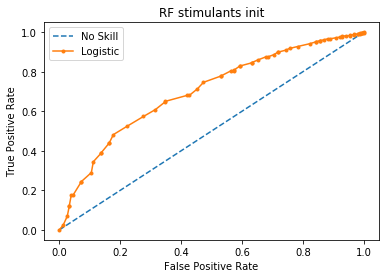

In [427]:
random_forest_stimulants_init = run_model(RandomForestClassifier(), stimulants_init, 'stimulants', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_init)

X_train: (3031, 51) X_test: (1494, 51) y_train: (3031,) y_test: (1494,)
Accuracy: 0.8775100401606426
F1: 0.9347128077060292
Precision: 0.8780160857908847
Recall: 0.9992372234935164
AUC: 0.649


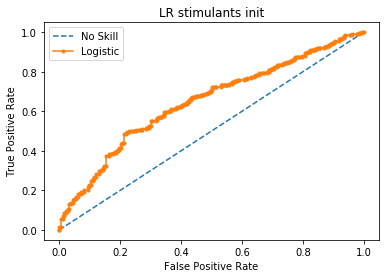

In [428]:
stimulants_init_logistic_regression = get_logistic_regression_features(stimulants_init)

logistic_regression_stimulants_init = run_model(LogisticRegression(max_iter=1000), stimulants_init_logistic_regression, 'stimulants', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_init)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.8928571428571429
F1: 0.9433962264150945
Precision: 0.8928571428571429
Recall: 1.0
AUC: 0.610


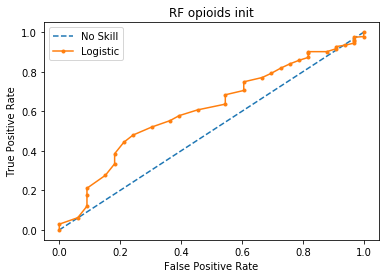

In [429]:
random_forest_opioids_init = run_model(RandomForestClassifier(), opioids_init, 'opioids', 'init')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_init)

X_train: (625, 51) X_test: (308, 51) y_train: (625,) y_test: (308,)
Accuracy: 0.8993506493506493
F1: 0.9466437177280551
Precision: 0.9166666666666666
Recall: 0.9786476868327402
AUC: 0.727


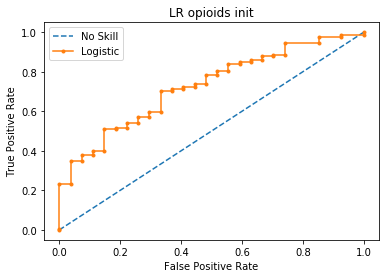

In [430]:
opioids_init_logistic_regression = get_logistic_regression_features(opioids_init)

logistic_regression_opioids_init = run_model(LogisticRegression(max_iter=1000), opioids_init_logistic_regression, 'opioids', 'init')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_init)

X_train: (3031, 36) X_test: (1494, 36) y_train: (3031,) y_test: (1494,)
Accuracy: 0.6412315930388219
F1: 0.7541284403669725
Precision: 0.6699266503667481
Recall: 0.8625393494228751
AUC: 0.621


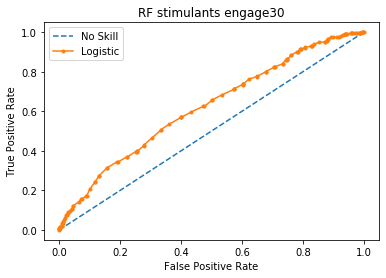

In [431]:
random_forest_stimulants_engage30 = run_model(RandomForestClassifier(), stimulants_engage30, 'stimulants', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_stimulants_engage30)

X_train: (3031, 51) X_test: (1494, 51) y_train: (3031,) y_test: (1494,)
Accuracy: 0.6506024096385542
F1: 0.7644404332129964
Precision: 0.6637931034482759
Recall: 0.9010638297872341
AUC: 0.595


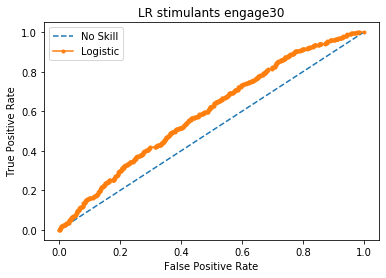

In [432]:
stimulants_engage30_logistic_regression = get_logistic_regression_features(stimulants_engage30)

logistic_regression_stimulants_engage30 = run_model(LogisticRegression(max_iter=1000), stimulants_engage30_logistic_regression, 'stimulants', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_stimulants_engage30)

X_train: (625, 36) X_test: (308, 36) y_train: (625,) y_test: (308,)
Accuracy: 0.6883116883116883
F1: 0.8032786885245901
Precision: 0.7205882352941176
Recall: 0.9074074074074074
AUC: 0.575


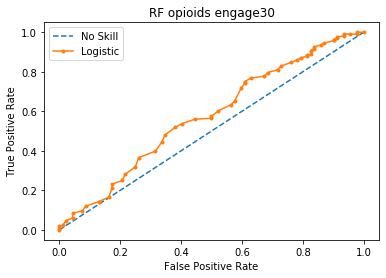

In [433]:
random_forest_opioids_engage30 = run_model(RandomForestClassifier(), opioids_engage30, 'opioids', 'engage30')
feature_importance_random_forest = feature_importance_random_forest.join(random_forest_opioids_engage30)

X_train: (625, 51) X_test: (308, 51) y_train: (625,) y_test: (308,)
Accuracy: 0.7077922077922078
F1: 0.8170731707317074
Precision: 0.7335766423357665
Recall: 0.9220183486238532
AUC: 0.664


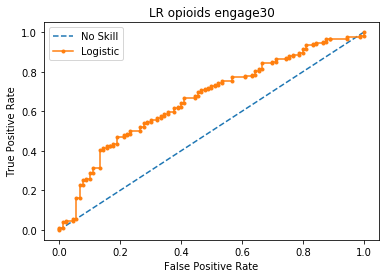

In [434]:
opioids_engage30_logistic_regression = get_logistic_regression_features(opioids_engage30)

logistic_regression_opioids_engage30 = run_model(LogisticRegression(max_iter=1000), opioids_engage30_logistic_regression, 'opioids', 'engage30')
feature_importance_logistic_regression = feature_importance_logistic_regression.join(logistic_regression_opioids_engage30)

### Feature Importance Analysis

In [435]:
def func(row, groups):
    result = 0
    for group in groups:
        result += abs(row[group])
    return result

feature_importance_random_forest['abs sum'] = feature_importance_random_forest.apply(lambda row: func(row, feature_importance_random_forest.columns), axis=1)
feature_importance_random_forest = feature_importance_random_forest.sort_values(by='abs sum', ascending=False)

feature_importance_logistic_regression['abs sum'] = feature_importance_logistic_regression.apply(lambda row: func(row, feature_importance_logistic_regression.columns), axis=1)
feature_importance_logistic_regression = feature_importance_logistic_regression.sort_values(by='abs sum', ascending=False)

In [436]:
feature_importance_random_forest.head() 

,RF stimulants init,RF opioids init,RF stimulants engage30,RF opioids engage30,abs sum
feature,,,,,
ada_0_cd,0.104832,0.113719,0.100904,0.108122,0.427578
cjsig_0_cd,0.046983,0.047720,0.041553,0.043951,0.180207
SESg_0_cd,0.037166,0.037009,0.036350,0.051537,0.162063
gcsg_0_cd,0.041984,0.040499,0.039989,0.038101,0.160573
gvsg_cd,0.043595,0.038818,0.040775,0.033955,0.157143


In [437]:
feature_importance_logistic_regression.head(10) 

,LR stimulants init,LR opioids init,LR stimulants engage30,LR opioids engage30,abs sum
feature,,,,,
loc_cd_1,2.295717,1.957676,0.325114,-0.328328,4.906835
loc_cd_9,-0.545397,-0.708646,1.138214,1.117706,3.509962
dldiag_cd,0.046604,1.788712,0.184332,0.248517,2.268166
unemplmt_cd,1.323216,0.494569,-0.150924,-0.279934,2.248643
lrig_0_cd_0,-0.228702,0.858041,-0.346228,0.569855,2.002826
adhdg_0_cd_0,0.537625,0.465487,0.226333,0.548972,1.778417
loc_cd_2,1.037347,0.025848,-0.358681,0.304654,1.726530
dssg_0_cd_2,-0.255713,1.002263,-0.184799,-0.240231,1.683006
cjsig_0_cd_2,0.649005,0.150541,0.446749,-0.402469,1.648764


In [438]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('feature_importance.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
feature_importance_random_forest.to_excel(writer, sheet_name='Random Forest')
feature_importance_logistic_regression.to_excel(writer, sheet_name='Logistic Regression')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [439]:
total_seconds = int(time.time() - start_time)
hours = total_seconds // (60 * 60)
minutes = (total_seconds - hours*60) // 60
seconds = (total_seconds - hours*60) % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 0 minutes 13 seconds ---


In [440]:
# notes

# distribution of engage30 is better (~60% positive rate) than init (~90% positive rate)
# based on the low coefficients for all the features for init predictions it looks like the 
#   model is always predicting the same thing
# engage30 dominates feature importance